In [1]:
## Required Imports
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import os
from pathlib import Path
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import cv2



### Preprocessing

In [2]:
train_path = "./rsna-pneumonia-detection-challenge/stage_2_train_images"
test_path = "./rsna-pneumonia-detection-challenge/stage_2_test_images"
train_labels = "./rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"

In [3]:
train_label_df = pd.read_csv(train_labels)
train_label_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [4]:
print(train_label_df.shape)
train_label_df = train_label_df.drop_duplicates("patientId")
train_label_df = train_label_df.reset_index()
print(train_label_df.shape)

(30227, 6)
(26684, 7)


([<matplotlib.axis.XTick at 0x32602ec40>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

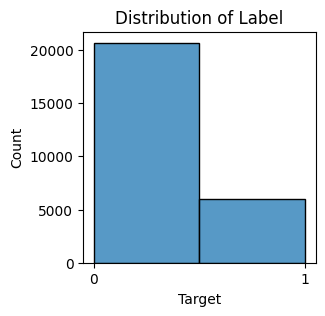

In [5]:
# Class Balance
plt.figure(figsize=(3,3))
sns.histplot(data=train_label_df, x="Target", bins=2)
plt.title("Distribution of Label")
plt.xticks([0,1])

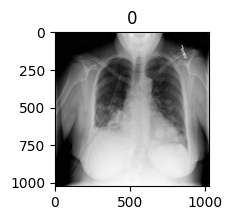

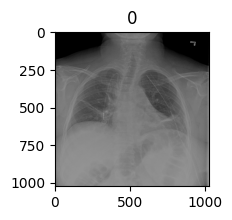

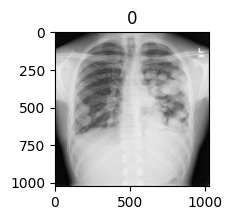

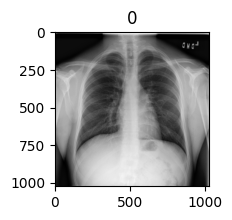

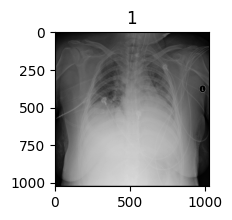

In [6]:
# View the images
for i in range(5):
    patient_id = train_label_df["patientId"].loc[i] + ".dcm"
    label = train_label_df["Target"].loc[i]
    image_path = Path(train_path, patient_id)
    img_arr = pydicom.read_file(image_path).pixel_array

    plt.figure(figsize=(2,2))
    plt.imshow(img_arr, cmap= "gray")
    plt.title (label)


In [7]:
# Explore pixel values
patient_id = train_label_df["patientId"].iloc[0] + ".dcm"
image_path = Path(train_path, patient_id)
img_arr = pydicom.read_file(image_path).pixel_array
print (f'Min: {np.min(img_arr)}')
print (f'Max: {np.max(img_arr)}')
print(f'Shape: {img_arr.shape}')

Min: 0
Max: 245
Shape: (1024, 1024)


In [8]:
sums = 0
sums_squared = 0

for i in range(train_label_df.shape[0]):
    id  = train_label_df["patientId"].iloc[i] + ".dcm"
    label = train_label_df["Target"].loc[i]
    image_path = Path(train_path, patient_id)
    img_arr = pydicom.read_file(image_path).pixel_array

    img_processed = img_arr/255
    img_compressed = cv2.resize(img_processed, (224, 224)).astype(np.float16)

    if i <= 21000:
        # data_path = Path("data/training/" + str(label))
        # data_path.mkdir(parents=True, exist_ok=True)
        # np.save(data_path/id, img_compressed)

        normalizer = img_compressed.shape[0] * img_compressed.shape[1]
        sums += np.sum(img_compressed) / normalizer
        sums_squared += (np.power(img_compressed, 2).sum()) / normalizer
    # else:
    #     data_path = Path("data/val/" + str(label))
    #     data_path.mkdir(parents=True, exist_ok=True)
    #     np.save(data_path/id, img_compressed)

In [9]:
mean = sums / 21000
std = np.sqrt(sums_squared / 21000 - (mean**2))
print(f'mean: {mean}')
print(f'std: {std}')

mean: 0.4716423560495689
std: 0.2895685766566728


In [10]:
### Transormation

train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])



In [11]:
## Load data
def load_file(path):
    return np.load(path).astype(np.float32)

train_dataset = torchvision.datasets.DatasetFolder(
    "data/training/",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    "data/val/",
    loader=load_file, extensions="npy", transform=val_transforms)

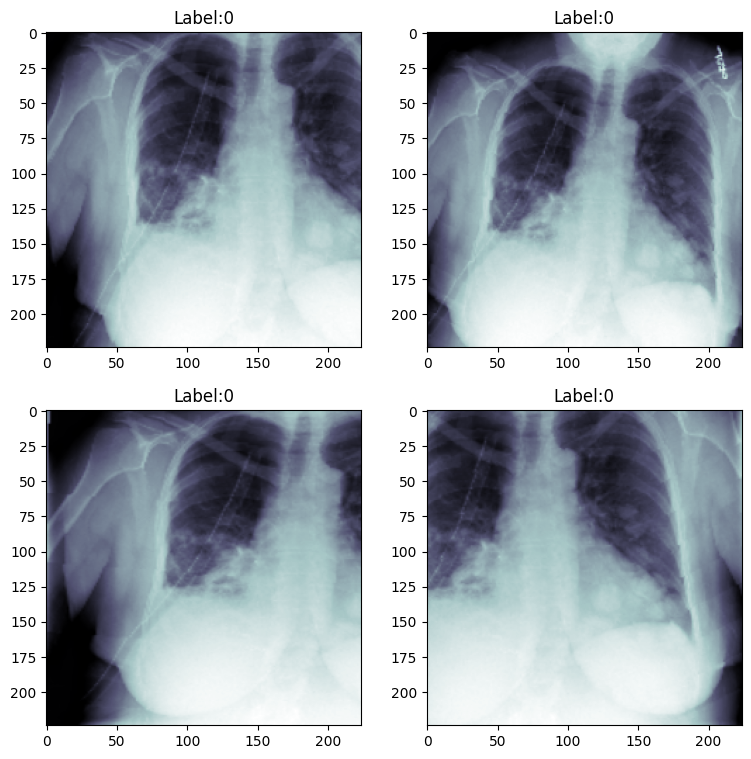

In [12]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

In [13]:
batch_size = 64#TODO
num_workers = 4# TODO

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 21001 train images and 5683 val images


### Model

In [14]:
class Rsna_pneumonia(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()

        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')

        
    
    def forward(self, data):
        return self.model(data)
    
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  
        pred = self(x_ray)[:,0]  
        loss = self.loss_fn(pred, label)  
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss

    def training_epoch_end(self, outs):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())
        
        
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0] 

        loss = self.loss_fn(pred, label)
        
        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    def validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())
    
    def configure_optimizers(self):
        return [self.optimizer]
        
    

In [15]:
model = Rsna_pneumonia() 

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Rsna_pneumonia.load_from_checkpoint("weights/weights_1.ckpt")
model.eval()
model.to(device);

/Users/kghatole/miniforge3/envs/tf/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint weights/weights_1.ckpt`


In [17]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/5683 [00:00<?, ?it/s]

In [18]:
acc = torchmetrics.Accuracy(task='binary')(preds, labels)
precision = torchmetrics.Precision(task='binary')(preds, labels)
recall = torchmetrics.Recall(task='binary')(preds, labels)
cm = torchmetrics.ConfusionMatrix(task='binary', num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task='binary', num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.8194615244865417
Val Precision: 0.0
Val Recall: 0.0
Confusion Matrix:
 tensor([[4657,    0],
        [1026,    0]])
Confusion Matrix 2:
 tensor([[4657,    0],
        [1026,    0]])
